In [2]:
import pandas as pd
data = pd.read_csv("data/train.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/train.csv'

In [ ]:
data.head()

In [ ]:
data.dropna()

In [ ]:
data = data.drop(labels=['Organisation','Device name', 'datetime', 'Geolocation', 'Device ID'], axis=1)

In [143]:
data.head()

class AirQuality:
    def __init__(self, PM1, PM25, PM10, Temperature, NO2, CO, O3):
        self.PM1 = PM1
        self.PM25 = PM25
        self.PM10 = PM10
        self.Temperature = Temperature
        self.NO2 = NO2
        self.CO = CO
        self.O3 = O3


class Good:
    @staticmethod
    def is_good(air_quality):
        return (air_quality.PM25 < 12 and
                air_quality.PM10 < 20 and
                air_quality.NO2 < 40 and
                air_quality.CO < 0.5 and
                air_quality.O3 < 60)


class Dust:
    @staticmethod
    def is_dust(air_quality):
        return (12 <= air_quality.PM25 < 35 or
                20 <= air_quality.PM10 < 50)


class Polluted:
    @staticmethod
    def is_polluted(air_quality):
        return (air_quality.PM25 >= 35 or
                air_quality.NO2 >= 40 or
                air_quality.CO >= 1 or
                air_quality.O3 >= 80)


class TooPolluted:
    @staticmethod
    def is_too_polluted(air_quality):
        return (air_quality.PM25 >= 55 or
                air_quality.NO2 >= 80 or
                air_quality.CO >= 2 or
                air_quality.O3 >= 120)


class Fire:
    @staticmethod
    def is_fire(air_quality):
        return (air_quality.PM25 >= 150 or
                air_quality.PM10 >= 150)




In [144]:
import pandas as pd

# Assuming the AirQuality, Good, Dust, Polluted, TooPolluted, and Fire classes are already defined

def classify_row(row):
    # Create an AirQuality object for the current row
    air_quality = AirQuality(
        row['PM1'], row['PM25'], row['PM10'], 
        row['Temperature'], row['NO2'], row['CO'], row['O3']
    )
    
    # Check for the most severe condition in order of priority
    if Fire.is_fire(air_quality):
        return "Fire"
    if TooPolluted.is_too_polluted(air_quality):
        return "Too Polluted"
    if Polluted.is_polluted(air_quality):
        return "Polluted"
    if Dust.is_dust(air_quality):
        return "Dust"
    if Good.is_good(air_quality):
        return "Good"
    
    # If none of the conditions are met, return "Unknown" (optional)
    return "Unknown"

# Load the dataset
dataX = pd.read_csv("datasets/train.csv")

# Apply the classification function to each row in the DataFrame
dataX['Air_C'] = dataX.apply(classify_row, axis=1)

# Save the results to a new CSV file
dataX.to_csv('classified_data_combined_d.csv', index=False)

print("Classification completed and saved to 'classified_data_combined_d.csv'.")


Classification completed and saved to 'classified_data_combined_d.csv'.


In [20]:
combined_data = pd.read_csv("datasets/train.csv")
combined_data= combined_data.drop(labels=['Organisation','Device name', 'datetime', 'Geolocation', 'Device ID'], axis=1)

In [21]:
combined_data['Air_C'].unique()

KeyError: 'Air_C'

In [5]:
mapping = {
    'Too Polluted': 1,
    'Good': 2,
    'Unknown': 3,
    'Dust' : 4,
    'Fire' : 6,
    'Polluted' : 5
    
}

In [6]:
combined_data["Air_C_encoded"] = combined_data['Air_C_encoded'].fillna(0).astype(int)

In [5]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

combined_data['Air_C_encoded'] = encoder.fit_transform(combined_data['Air_C'])



In [9]:
combined_data['Air_C_encoded'].unique()

array([4, 2, 5, 0, 1, 3])

In [24]:
# Check for missing or infinite values in the dataset
print(combined_data.isna().sum())  # Check for missing values
print((combined_data == float('inf')).sum())  # Check for infinite values

# Remove or impute missing or infinite values
combined_data = combined_data.replace([float('inf'), -float('inf')], float('nan'))
combined_data = combined_data.dropna()  # Drop rows with NaN values


PM1                0
PM25               0
PM10               0
Temperature        0
NO2             7814
CO              2637
O3              8626
AQI_PM10       13548
AQI_PM25       13548
AQI_NO2        13548
AQI_O3         13548
AQI_CO         13548
AQI_Max        13548
dtype: int64
PM1            0
PM25           0
PM10           0
Temperature    0
NO2            0
CO             0
O3             0
AQI_PM10       0
AQI_PM25       0
AQI_NO2        0
AQI_O3         0
AQI_CO         0
AQI_Max        0
dtype: int64


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import joblib

# Assuming combined_data is a valid DataFrame

# Check for missing or infinite values
combined_data = combined_data.replace([float('inf'), -float('inf')], float('nan'))
combined_data = combined_data.dropna()

# Split the data
X = combined_data[["PM25", "PM10", "Temperature", "NO2", "CO", "O3"]].values
y = combined_data[["AQI_PM10","AQI_PM25","AQI_NO2","AQI_O3","AQI_CO","AQI_Max"]].values  # Multi-output regression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Scale the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Scale the target variables
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

# Define the model
model = Sequential([
    Dense(256, input_dim=X.shape[1], activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='linear')  # Linear activation for multi-output regression
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Save the model and scalers
model.save('air_quality_model_regression.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(y_scaler, 'y_scaler.pkl')


Epoch 1/50
2105/2105 [==============================] - 6s 3ms/step - loss: 0.2002 - accuracy: 0.8577 - val_loss: 0.4026 - val_accuracy: 0.9116
Epoch 2/50
2105/2105 [==============================] - 5s 2ms/step - loss: 0.0909 - accuracy: 0.9064 - val_loss: 0.4907 - val_accuracy: 0.9152
Epoch 3/50
2105/2105 [==============================] - 6s 3ms/step - loss: 0.0807 - accuracy: 0.9154 - val_loss: 0.3491 - val_accuracy: 0.9176
Epoch 4/50
2105/2105 [==============================] - 6s 3ms/step - loss: 0.0703 - accuracy: 0.9208 - val_loss: 0.2614 - val_accuracy: 0.9298
Epoch 5/50
2105/2105 [==============================] - 6s 3ms/step - loss: 0.0657 - accuracy: 0.9247 - val_loss: 0.2654 - val_accuracy: 0.9313
Epoch 6/50
2105/2105 [==============================] - 5s 2ms/step - loss: 0.0573 - accuracy: 0.9289 - val_loss: 0.2782 - val_accuracy: 0.9299
Epoch 7/50
2105/2105 [==============================] - 5s 3ms/step - loss: 0.0517 - accuracy: 0.9315 - val_loss: 0.2189 - val_accuracy:

c:\Users\marks\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['y_scaler.pkl']

In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Get predictions for the test set
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Convert true labels back from one-hot encoding to class indices
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Assuming 'encoder.classes_' contains the class labels
# Get the class labels from the encoder
class_labels = encoder.classes_

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


1053/1053 [==============================] - 2s 1ms/step
Test Accuracy: 0.94

Classification Report:


ValueError: Number of classes, 5, does not match size of target_names, 6. Try specifying the labels parameter

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate predictions
y_pred = model.predict(X_test)

# Evaluate regression performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


1053/1053 [==============================] - 2s 2ms/step
Mean Squared Error: 0.012981967136406003
Mean Absolute Error: 0.033557400445453224
R² Score: 0.9877413161604739


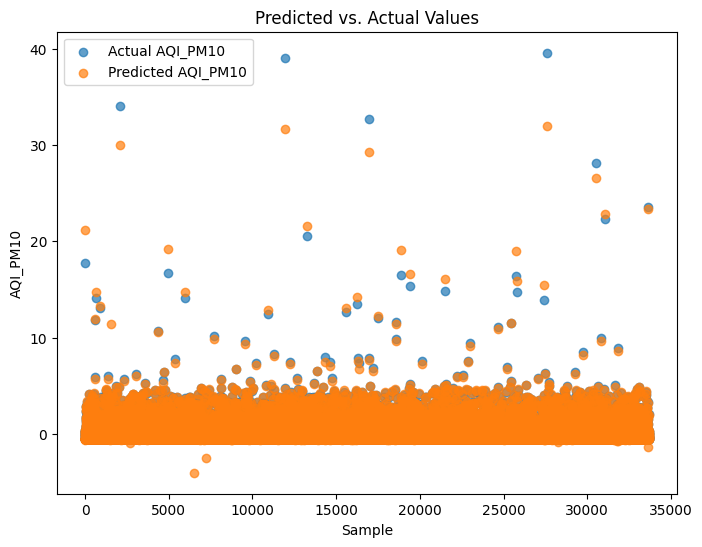

In [32]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test[:, 0], label="Actual AQI_PM10", alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred[:, 0], label="Predicted AQI_PM10", alpha=0.7)
plt.xlabel("Sample")
plt.ylabel("AQI_PM10")
plt.title("Predicted vs. Actual Values")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Define the range of values based on the original dataset
data_range = {
    "PM25": (0, 20),
    "PM10": (0, 50),
    "Temperature": (15, 35),
    "NO2": (10, 40),
    "CO": (100, 1000),
    "O3": (5, 30),
}

# Generate synthetic data
num_samples = 10  # Number of synthetic samples to generate
synthetic_data = {
    feature: np.random.uniform(low, high, num_samples)
    for feature, (low, high) in data_range.items()
}

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Preview the synthetic data
print("Synthetic Data:")
print(synthetic_df)

# Normalize the data (assuming the model was trained on normalized data)
synthetic_data_normalized = scaler.transform(synthetic_df)

# Predict using the model
predictions = model.predict(synthetic_data_normalized)

# Denormalize the predictions
predictions_denormalized = scaler.inverse_transform(predictions)

# Display denormalized predictions
print("\nDenormalized Predictions:")
for i, pred in enumerate(predictions_denormalized):
    print(f"Sample {i+1}: Predicted AQI values: {pred}")


Synthetic Data:
        PM25       PM10  Temperature        NO2          CO         O3
0   4.512958   7.393232    31.310369  15.327721  366.025745  19.624585
1   0.924103  42.341147    34.138021  13.949990  753.006405   9.845816
2   2.302000  44.045275    26.596759  38.669707  271.790749   9.761424
3  16.304096  48.810399    20.050345  27.348963  717.765651  22.031756
4  15.022759  26.082937    26.067964  23.273462  148.485694   6.316564
5   9.825163  39.551742    16.087654  19.346083  219.569196  13.579917
6   9.512822  43.158589    34.893646  30.547848  569.900316  13.015732
7  15.906815  41.112555    30.607621  15.356973  481.264541  15.295264
8  17.546882  32.221117    15.628640  10.558307  625.141826  27.259988
9  16.657403  12.132401    17.342117  12.627903  142.421802  27.143418
1/1 [==============================] - 0s 19ms/step

Denormalized Predictions:
Sample 1: Predicted AQI values: [  5.9718256   7.0203266  14.059958   31.76041   330.28763     4.4767327]
Sample 2: Predicte

c:\Users\marks\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [1]:
import numpy as np
import pandas as pd

# Define the thresholds for AQI categories
AQI_THRESHOLDS = {
    "AQI_PM10": [0, 50, 100, 150, 200, 300],
    "AQI_PM25": [0, 50, 100, 150, 200, 300],
    "AQI_NO2": [0, 50, 100, 150, 200, 300],
    "AQI_O3": [0, 50, 100, 150, 200, 300],
    "AQI_CO": [0, 50, 100, 150, 200, 300],
    "AQI_Max": [0, 50, 100, 150, 200, 300]
}

# Define the AQI category names
AQI_CATEGORIES = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"]

# Function to classify AQI values based on thresholds
def classify_aqi(aqi_value, thresholds):
    for i, threshold in enumerate(thresholds[1:], start=1):
        if aqi_value <= threshold:
            return AQI_CATEGORIES[i - 1]
    return AQI_CATEGORIES[-1]  # Hazardous if higher than the last threshold

# Example synthetic data for AQI predictions (Assuming you have your synthetic predictions)
synthetic_predictions = np.array([
    [45, 30, 22, 80, 300, 100],  # Sample 1
    [75, 60, 120, 150, 250, 250],  # Sample 2
    [35, 45, 60, 120, 150, 180],  # Sample 3
    [150, 120, 150, 160, 200, 250],  # Sample 4
])

# Classify the predictions into AQI categories
classified_predictions = []
for i, prediction in enumerate(synthetic_predictions):
    classified = {
        "Sample": i + 1,
        "AQI_PM10": classify_aqi(prediction[0], AQI_THRESHOLDS["AQI_PM10"]),
        "AQI_PM25": classify_aqi(prediction[1], AQI_THRESHOLDS["AQI_PM25"]),
        "AQI_NO2": classify_aqi(prediction[2], AQI_THRESHOLDS["AQI_NO2"]),
        "AQI_O3": classify_aqi(prediction[3], AQI_THRESHOLDS["AQI_O3"]),
        "AQI_CO": classify_aqi(prediction[4], AQI_THRESHOLDS["AQI_CO"]),
        "AQI_Max": classify_aqi(prediction[5], AQI_THRESHOLDS["AQI_Max"]),
    }
    classified_predictions.append(classified)

# Convert classified predictions to DataFrame for better visualization
classified_df = pd.DataFrame(classified_predictions)

# Print the classified predictions
print(classified_df)


   Sample                        AQI_PM10                        AQI_PM25  \
0       1                            Good                            Good   
1       2                        Moderate                        Moderate   
2       3                            Good                            Good   
3       4  Unhealthy for Sensitive Groups  Unhealthy for Sensitive Groups   

                          AQI_NO2                          AQI_O3  \
0                            Good                        Moderate   
1  Unhealthy for Sensitive Groups  Unhealthy for Sensitive Groups   
2                        Moderate  Unhealthy for Sensitive Groups   
3  Unhealthy for Sensitive Groups                       Unhealthy   

                           AQI_CO         AQI_Max  
0                  Very Unhealthy        Moderate  
1                  Very Unhealthy  Very Unhealthy  
2  Unhealthy for Sensitive Groups       Unhealthy  
3                       Unhealthy  Very Unhealthy  


In [51]:
combined_data["PM25"].argmax

<bound method IndexOpsMixin.argmax of 0         3.0
1         6.0
2         7.0
3         0.0
4         4.0
         ... 
194989    0.0
195000    1.0
195001    0.0
195002    0.0
195003    0.0
Name: PM25, Length: 168379, dtype: float64>

In [ ]:
sentinelsat -u <user> -p <password> --location Berlin --sentinel 2 --cloud 30 --start NOW-1MONTH


In [129]:

dataF=pd.read_csv("data/train.csv")
stats = {}
for column in dataF.columns:  # Changed data to dataF
    if dataF[column].dtype in ['float64', 'int64']:  # Ensure the column contains numerical data
        min_value = dataF[column].min()
        max_value = dataF[column].max()
        range_value = max_value - min_value
        stats[column] = {'Min': min_value, 'Max': max_value, 'Range': range_value}

# 3. Display the results
for column, values in stats.items():
    print(f"Column: {column}")
    print(f"  Min value: {values['Min']}")
    print(f"  Max value: {values['Max']}")
    print(f"  Range: {values['Range']}\n")


Column: PM1
  Min value: 0.0
  Max value: 282.0
  Range: 282.0

Column: PM25
  Min value: 0.0
  Max value: 1397.0
  Range: 1397.0

Column: PM10
  Min value: 0.0
  Max value: 2223.0
  Range: 2223.0

Column: Temperature
  Min value: 1.6
  Max value: 44.2
  Range: 42.6

Column: NO2
  Min value: -45.1561303241
  Max value: 147207.3018771654
  Range: 147252.45800748948

Column: CO
  Min value: -354.561331401
  Max value: 15754.0424468676
  Range: 16108.6037782686

Column: O3
  Min value: -24.8082446947
  Max value: 27266.0476799685
  Range: 27290.8559246632

Column: AQI_PM10
  Min value: 0.0
  Max value: 468.0
  Range: 468.0

Column: AQI_PM25
  Min value: 0.0
  Max value: 500.0
  Range: 500.0

Column: AQI_NO2
  Min value: 0.0
  Max value: 323.0
  Range: 323.0

Column: AQI_O3
  Min value: 0.0
  Max value: 456.0
  Range: 456.0

Column: AQI_CO
  Min value: 0.0
  Max value: 202.0
  Range: 202.0

Column: AQI_Max
  Min value: 0.0
  Max value: 500.0
  Range: 500.0



In [ ]:
!sentinelsat -u <user> -p <password> --location Berlin --sentinel 2 --cloud 30 --start NOW-1MONTH


In [46]:
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
import joblib  # Ensure joblib is imported for scaler loading

# Load the saved scaler from the .pkl file
scaler = joblib.load('scaler.pkl')

# Load the trained model (Ensure that the model path is correct)
model = load_model('air_quality_model_regression.h5')  # Use your model's file path

# Define the thresholds for AQI categories including Fire and Dust
AQI_THRESHOLDS = {
    "AQI_PM10": [0, 30, 50, 100, 150, 200, 300],  # Fire and Dust are added as lower ranges
    "AQI_PM25": [0, 30, 50, 100, 150, 200, 300],
    "AQI_NO2": [0, 30, 50, 100, 150, 200, 300],
    "AQI_O3": [0, 30, 50, 100, 150, 200, 300],
    "AQI_CO": [0, 30, 50, 100, 150, 200, 300],
    "AQI_Max": [0, 30, 50, 100, 150, 200, 300]
}

# Define the AQI category names including Fire and Dust
AQI_CATEGORIES = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous", "Fire", "Dust"]

# Function to classify AQI values based on thresholds
def classify_aqi(aqi_value, thresholds):
    for i, threshold in enumerate(thresholds[1:], start=1):
        if aqi_value <= threshold:
            return AQI_CATEGORIES[i - 1]
    return AQI_CATEGORIES[-1]  # Hazardous if higher than the last threshold

# Assuming X_test is already available in your environment
# X_test should be a NumPy array or DataFrame with the same shape/features as the model expects
# Example: X_test could look like this:
# X_test = np.array([
#     [45, 30, 22, 80, 300, 100],  # Sample 1
#     [75, 60, 120, 150, 250, 250],  # Sample 2
#     [35, 45, 60, 120, 150, 180],  # Sample 3
#     [150, 120, 150, 160, 200, 250],  # Sample 4
# ])

# Normalize the X_test data before feeding it into the model
normalized_data = scaler.transform(X_test)

# Predict using the model
predictions = model.predict(normalized_data)

# Denormalize the predictions using the scaler (if needed)
denormalized_predictions = scaler.inverse_transform(predictions)

# Classify the denormalized predictions into AQI categories
classified_predictions = []
for i, prediction in enumerate(denormalized_predictions):
    classified = {
        "Sample": i + 1,
        "AQI_PM10": classify_aqi(prediction[0], AQI_THRESHOLDS["AQI_PM10"]),
        "AQI_PM25": classify_aqi(prediction[1], AQI_THRESHOLDS["AQI_PM25"]),
        "AQI_NO2": classify_aqi(prediction[2], AQI_THRESHOLDS["AQI_NO2"]),
        "AQI_O3": classify_aqi(prediction[3], AQI_THRESHOLDS["AQI_O3"]),
        "AQI_CO": classify_aqi(prediction[4], AQI_THRESHOLDS["AQI_CO"]),
        "AQI_Max": classify_aqi(prediction[5], AQI_THRESHOLDS["AQI_Max"]),
    }
    classified_predictions.append(classified)

# Convert classified predictions to DataFrame for better visualization
classified_df = pd.DataFrame(classified_predictions)

# Filter for only "Fire" and "Dust" categories
fire_dust_df = classified_df[
    (classified_df["AQI_PM10"].isin(["Fire", "Dust"])) |
    (classified_df["AQI_PM25"].isin(["Fire", "Dust"])) |
    (classified_df["AQI_NO2"].isin(["Fire", "Dust"])) |
    (classified_df["AQI_O3"].isin(["Fire", "Dust"])) |
    (classified_df["AQI_CO"].isin(["Fire", "Dust"])) |
    (classified_df["AQI_Max"].isin(["Fire", "Dust"]))
]

# Print the filtered DataFrame for Fire and Dust categories
print(fire_dust_df)


1053/1053 [==============================] - 2s 1ms/step
      Sample AQI_PM10 AQI_PM25 AQI_NO2 AQI_O3                          AQI_CO  \
6534    6535     Good     Good    Good   Dust  Unhealthy for Sensitive Groups   

        AQI_Max  
6534  Unhealthy  


In [52]:
import pandas as pd

# Load the dataset from the CSV file
data = pd.read_csv("datasets/train.csv")

# Get the maximum and minimum values for each column
max_values = data.max()
min_values = data.min()

# Print the maximum values for each column
print("Maximum values for each column:")
print(max_values)

# Print the minimum values for each column
print("\nMinimum values for each column:")
print(min_values)


Maximum values for each column:
Organisation           Liverpool City Council
Device name     Oxford St, Ingleburn ems-16ea
datetime            2024-03-19T22:49:57+01:00
Device ID                eui-0004a30b00ede399
PM1                                     282.0
PM25                                   1397.0
PM10                                   2223.0
Temperature                              44.2
NO2                             147207.301877
CO                               15754.042447
O3                                27266.04768
AQI_PM10                                468.0
AQI_PM25                                500.0
AQI_NO2                                 323.0
AQI_O3                                  456.0
AQI_CO                                  202.0
AQI_Max                                 500.0
Geolocation                -34.07001, 150.808
dtype: object

Minimum values for each column:
Organisation                             Campbelltown
Device name     Environmental monitorin

Failed to retrieve data: <!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">
<title>NASA POWER | Page Not Found</title>
<meta name="description" content="The requested NASA POWER page was not found.">
<meta name="viewport" content="width=device-width">
<style type="text/css" media="screen">
html {
	-webkit-font-smoothing: antialiased;
}

body {
	background:
		url();
	border-top: 5px solid #ed2b38;
	margin: 0;
	padding: 40px 0 0 0;
	text-align: center;
	color: #fff;
	font-family: "Helvetica Neue", "Helvetica", sans-serif;
}

a:link, a:visited {
	color: #fff;
	font-weight: 500;
}

.wrap {
	width: 900px;
	margin: 0 auto;
	padding-top: 80px;
	background:
		url()
		no-repeat top center;
}

h1 {
	font-weight: 900;
	font-size: 2.8em;
}

p {
	font-size: 1.2em;
	font-weight: 200;
	margin: 0 0 60px 0;
}

.earth {
	width: 300px;
	height: 300px;
	background:
		url();
	margin: 0 auto;
}

.orbit {
	width: 300px;
	height: 300px;
	backgro
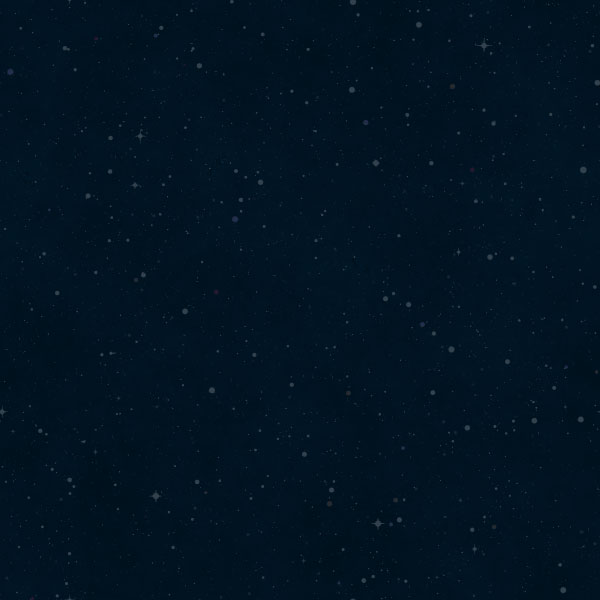
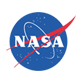
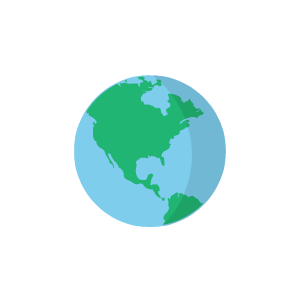
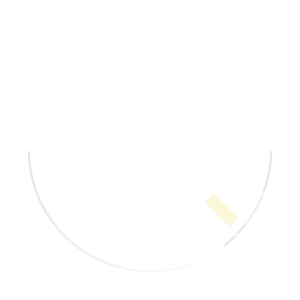

In [53]:
import requests

# Define parameters for NASA API
base_url = "https://power.larc.nasa.gov/api/temporal/daily/"
parameters = "PM2.5,PM10,TEMPERATURE,NO3,CO,O3"

# Customize your query
query = f"{base_url}?parameters={parameters}&start=2020-01-01&end=2020-12-31&latitude=40.7128&longitude=-74.0060&format=CSV"

# Send request to NASA API
response = requests.get(query)

# Save data as CSV
if response.status_code == 200:
    with open("nasa_air_quality.csv", "wb") as file:
        file.write(response.content)
else:
    print("Failed to retrieve data:", response.text)
